# Constructing GCNMLP for Drug-Aftereffect Prediction

## Packages & CUDA

In [5]:
import dgl.nn as dglnn
import pandas as pd
import dgl
import dgl.nn as dglnn
import torch.nn as nn
import dgl.function as fn
import torch.nn.functional as F
import numpy as np
from dgl.data.utils import generate_mask_tensor
import torch
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score,precision_recall_curve, auc, f1_score,precision_score, recall_score,average_precision_score,label_ranking_average_precision_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder , LabelBinarizer
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [6]:
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using GPU.")
else:
    print("CUDA is not available. PyTorch is using CPU.")

CUDA is not available. PyTorch is using CPU.


## Data Import & Encoding

In [7]:
df = pd.read_csv("./Dataset/Cleaned_Datasets/snap_dse.csv")
drug_id = df["# STITCH"]
side_effect = df["Individual Side Effect"]
edgelist_dse = zip(side_effect, drug_id)
dfs = df[['# STITCH','Individual Side Effect']]

In [8]:
col_names = ["left_side","right_side","similairity"]
drugsim = pd.read_csv("./Dataset/Cleaned_Datasets/snap_similarities.csv",
                      names=col_names, skiprows=1)
source = drugsim["left_side"]
destination = drugsim["right_side"]
similarity = drugsim["similairity"]
edgelist_dd = zip(source, destination, similarity)

In [9]:
le = preprocessing.LabelEncoder()

le.fit(dfs['# STITCH'])
dfs['drug_id']=le.transform(dfs['# STITCH'])
drugsim['drug_id_left']=le.transform(drugsim['left_side'])
drugsim['drug_id_right']=le.transform(drugsim['right_side'])

le.fit(dfs['Individual Side Effect'])
dfs['se_id']=le.transform(dfs['Individual Side Effect'])

In [10]:
drug_id = torch.LongTensor(dfs['drug_id'])
side_id = torch.LongTensor(dfs['se_id'])

src = torch.LongTensor(drugsim['drug_id_left'])
dst = torch.LongTensor(drugsim['drug_id_right'])

## Graph Construction

In [11]:
dse = dgl.heterograph({
    ('drug_id', 'relate', 'side_id'): (drug_id, side_id),
    ('side_id', 'relate-by', 'drug_id'): (side_id, drug_id),
    ('drug_id','similar','drug_id'):(src,dst),
    ('drug_id','similar-by','drug_id'):(dst,src)
})

# drug-drug similarity
edge_weight_dd = torch.tensor(drugsim['similairity'].to_numpy())
dse.edges['similar'].data['sim'] = edge_weight_dd
dse.edges['similar-by'].data['sim'] = edge_weight_dd

u,v = dse.edges(etype='relate')

# put id on edges ('drug_id', 'relate', 'side_id')
edge_ids = np.arange(dse.number_of_edges(('drug_id', 'relate', 'side_id')))

adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))

adj_neg = 1 - adj.todense()
neg_u, neg_v = np.where(adj_neg != 0)

## GCNMLP

In [12]:
# GCN
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        # featureless embedding
        embed_dict = {ntype : nn.Parameter(torch.Tensor(dse.number_of_nodes(ntype), in_feats)) # in=10
                      for ntype in dse.ntypes}
        for key, embed in embed_dict.items():
            nn.init.xavier_uniform_(embed)
        self.embed = nn.ParameterDict(embed_dict)
        # create layer
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats) # 10,20
            for rel in rel_names}, aggregate='sum')

        self.conv2 = dglnn.HeteroGraphConv({
          rel: dglnn.GraphConv(hid_feats, hid_feats) # 20,20
          for rel in rel_names}, aggregate='sum')

        self.conv3 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats) # 20,5
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph):
        # inputs are features of nodes
        h = self.conv1(graph, self.embed)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv3(graph, h)
        return h

In [13]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W1 = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W1(h)}

    def forward(self, g, h, etype):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(lambda edges: self.apply_edges(edges), etype=etype)
            return g.edata['score']

In [14]:
class GCNMLP(nn.Module):
    def __init__(self, in_features, hidden_features, mlp_hidden, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, mlp_hidden, rel_names)
        self.pred = MLPPredictor(mlp_hidden, 1)
    def forward(self, g, pos_g,neg_g, etype):
        h = self.sage(g) # process incomplete dse, output information
        pred_pos_g = self.pred(pos_g, h, etype) # use information inferring pos_g graph
        pred_neg_g = self.pred(neg_g, h, etype) # use information inferreing neg_g graph
        pos_scores = pred_pos_g[etype]
        neg_scores = pred_neg_g[etype]

        return torch.sigmoid(pos_scores), torch.sigmoid(neg_scores)

## Training

In [15]:
fprd = dict()
tprd = dict()
roc_aucd = dict()
precd = dict()
recalld = dict()
auc_prd = dict()

In [16]:
neg_eids = np.random.choice(len(neg_u), dse.number_of_edges(('drug_id', 'relate', 'side_id')))

In [17]:
FOLDS = 10
sz = dse.number_of_edges(('drug_id', 'relate', 'side_id'))
eids = np.arange(sz)
eids_pm = eids
test_size = fsz = int(sz /10)
np.random.shuffle(eids_pm)
neg_eids_pm = neg_eids

In [18]:
IDX = u,v
IDX_neg = neg_u,neg_v
offset = 0
AUC_roc_train = np.zeros(FOLDS)
AUC_roc_valid = np.zeros(FOLDS)
AUC_roc_test = np.zeros(FOLDS)
AUC_pr_train = np.zeros(FOLDS)
AUC_pr_valid = np.zeros(FOLDS)
AUC_pr_test = np.zeros(FOLDS)
F1_micro_test = np.zeros(FOLDS)
F1_macro_test = np.zeros(FOLDS)
F1_weight_test = np.zeros(FOLDS)
Prec_micro_test = np.zeros(FOLDS)
Prec_macro_test = np.zeros(FOLDS)
Prec_weight_test  = np.zeros(FOLDS)
Recall_micro_test = np.zeros(FOLDS)
Recall_macro_test = np.zeros(FOLDS)
Recall_weight_test = np.zeros(FOLDS)

algod = {}
losses = []

In [20]:
def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    prediction_int = np.zeros_like(scores)
    prediction_int[scores > 0.5] = 1
    f1_micro = f1_score(labels, prediction_int, average='micro',zero_division=0)
    f1_macro = f1_score(labels, prediction_int, average='macro',zero_division=0)
    f1_weight = f1_score(labels, prediction_int, average='weighted',zero_division=0)
    prec_micro = precision_score(labels, prediction_int, average='micro',zero_division=0)
    prec_macro = precision_score(labels, prediction_int, average='macro',zero_division=0)
    prec_weight = precision_score(labels, prediction_int, average='weighted',zero_division=0)
    recall_micro = recall_score(labels, prediction_int, average='micro',zero_division=0)
    recall_macro = recall_score(labels, prediction_int, average='macro',zero_division=0)
    recall_weight = recall_score(labels, prediction_int, average='weighted',zero_division=0)

    prec, recall, _ = precision_recall_curve(labels,scores)
    pr_auc_score = auc(recall, prec)

    fpr, tpr, _ = metrics.roc_curve(labels,scores)
    roc_auc_score = metrics.auc(fpr, tpr)

    return roc_auc_score, pr_auc_score, f1_micro, f1_macro, f1_weight, prec_micro, prec_macro, prec_weight, recall_micro,recall_macro, recall_weight,prec, recall, fpr, tpr

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).squeeze(1)
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

In [61]:
for f in range(FOLDS):
    print("== Fold:",f," ==")

    fold_loss = []

    test_pos_u, test_pos_v = idx_test = u[eids_pm[offset:offset+fsz]], v[eids_pm[offset:offset+fsz]]
    test_neg_u, test_neg_v = idx_test_neg = neg_u[neg_eids_pm[offset:offset+fsz]], neg_v[neg_eids_pm[offset:offset+fsz]]


    # training set
    train_pos_u, train_pos_v = u[eids_pm[np.r_[:offset,offset + fsz:len(eids_pm)]]], v[eids_pm[np.r_[:offset,offset + fsz:len(eids_pm)]]]
    # print('length of train_pos ',len(train_pos_u))
    train_neg_u, train_neg_v = neg_u[neg_eids_pm[np.r_[:offset,offset + fsz:len(neg_eids_pm)]]], neg_v[neg_eids_pm[np.r_[:offset,offset + fsz:len(neg_eids_pm)]]]
    # print('length of train_neg ',len(train_neg_u))

    max_drug_id = max(train_pos_u.max(), test_pos_u.max())
    max_side_id = max(train_pos_v.max(), test_pos_v.max())

    # sub Graph: train_pos_g
    num_nodes_dict = {'drug_id': max_drug_id + 1, 'side_id': max_side_id + 1}
    train_pos_g = dgl.heterograph({
        ('drug_id', 'relate', 'side_id'): (train_pos_u, train_pos_v),
        ('side_id', 'relate-by', 'drug_id'): (train_pos_v, train_pos_u),
        ('drug_id','similar','drug_id'):(src,dst),
        ('drug_id','similar-by','drug_id'):(dst,src)

    },num_nodes_dict=num_nodes_dict)
    train_pos_g.edges['similar'].data['sim'] = edge_weight_dd
    train_pos_g.edges['similar-by'].data['sim'] = edge_weight_dd

    # sub Graph: train_neg_g
    train_neg_g = dgl.heterograph({
    ('drug_id', 'relate', 'side_id'): (train_neg_u, train_neg_v),
    ('side_id', 'relate-by', 'drug_id'): (train_neg_v, train_neg_u),
    ('drug_id','similar','drug_id'):(src,dst),
    ('drug_id','similar-by','drug_id'):(dst,src)

    },num_nodes_dict=num_nodes_dict)
    train_neg_g.edges['similar'].data['sim'] = edge_weight_dd
    train_neg_g.edges['similar-by'].data['sim'] = edge_weight_dd
    test_pos_g = dgl.heterograph({
    ('drug_id', 'relate', 'side_id'): (test_pos_u, test_pos_v),
    ('side_id', 'relate-by', 'drug_id'): (test_pos_v, test_pos_u),
    ('drug_id','similar','drug_id'):(src,dst),
    ('drug_id','similar-by','drug_id'):(dst,src)

    },num_nodes_dict=num_nodes_dict)
    test_pos_g.edges['similar'].data['sim'] = edge_weight_dd
    test_pos_g.edges['similar-by'].data['sim'] = edge_weight_dd

    # sub Graph: test_neg_g
    test_neg_g = dgl.heterograph({
    ('drug_id', 'relate', 'side_id'): (test_neg_u, test_neg_v),
    ('side_id', 'relate-by', 'drug_id'): (test_neg_v, test_neg_u),
    ('drug_id','similar','drug_id'):(src,dst),
    ('drug_id','similar-by','drug_id'):(dst,src)

    },num_nodes_dict=num_nodes_dict)
    test_neg_g.edges['similar'].data['sim'] = edge_weight_dd
    test_neg_g.edges['similar-by'].data['sim'] = edge_weight_dd

    # train_g: remove test set only
    train_g = dgl.remove_edges(dse, eids_pm[offset:offset+fsz],'relate')

    train_g = dgl.remove_edges(train_g, eids_pm[offset:offset+fsz],'relate-by')

    # print(train_g.etypes)
    # print(type(train_g))
    # print(type(train_pos_g))
    # print(type(train_neg_g))

    model = GCNMLP(10, 20, 5, train_g.etypes) # inputfeatures=10, hidden_features=20, mlp_hidden=5, relation_names: train_g.etypes
    opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for epoch in range(300):
        pos_score, neg_score = model(train_g,train_pos_g, train_neg_g, ('drug_id', 'relate', 'side_id'))
        loss = compute_loss(pos_score, neg_score)
        opt.zero_grad()
        loss.backward()
        opt.step()
        fold_loss.append(loss.item())
        if epoch % 20==0:
            print('the',epoch,'loss=',loss.item())
            # fold_loss.append(loss.item())
            with torch.no_grad():
                roc_auc_score_train, pr_auc_score_train , f1_micro_train, _ ,  _ ,  _ ,  _ ,  _ ,  _ , _ ,  _, prec, recall, fpr, tpr= compute_auc(pos_score, neg_score)
                # print('roc_auc:',roc_auc_score_train,'f1 micro:',f1_micro_train)

    # test set
    with torch.no_grad():
        print("Result:")
        print('AUC-ROC-TRAIN:', roc_auc_score_train,'AUC-PR-TRAIN:', pr_auc_score_train)
        AUC_roc_train[f] = roc_auc_score_train
        AUC_pr_train[f] = pr_auc_score_train
        pos_score, neg_score = model(train_g,test_pos_g, test_neg_g, ('drug_id', 'relate', 'side_id'))
        roc_auc_score_test,pr_auc_score_test, f1_micro_test, f1_macro_test, f1_weight_test, prec_micro_test, prec_macro_test, prec_weight_test, recall_micro_test,recall_macro_test, recall_weight_test, prec, recall, fpr, tpr = compute_auc(pos_score, neg_score)
        print('AUC-ROC-TEST:', roc_auc_score_test,'AUC-PR-TEST:', pr_auc_score_test)
        AUC_roc_test[f] = roc_auc_score_test
        AUC_pr_test[f] = pr_auc_score_test
        F1_micro_test[f] = f1_micro_test
        F1_macro_test[f]  = f1_macro_test
        F1_weight_test[f]  = f1_weight_test
        Prec_micro_test[f]  = prec_micro_test
        Prec_macro_test[f]  = prec_macro_test
        Prec_weight_test[f]   = prec_weight_test
        Recall_micro_test[f]  = recall_micro_test
        Recall_macro_test[f]  = recall_macro_test
        Recall_weight_test[f] = recall_weight_test

        algod['fold'+str(f)] = {}
        algod['fold'+str(f)]['gcnmlp'] = {}
        algod['fold'+str(f)]['gcnmlp']['fpr'] = fpr
        algod['fold'+str(f)]['gcnmlp']['tpr'] = tpr
        algod['fold'+str(f)]['gcnmlp']['roc_auc'] = roc_auc_score_test
        algod['fold'+str(f)]['gcnmlp']['prec'] = prec
        algod['fold'+str(f)]['gcnmlp']['recall'] = recall
        algod['fold'+str(f)]['gcnmlp']['auc_pr'] = pr_auc_score_test
        algod['fold'+str(f)]['gcnmlp']['F1_macro'] = f1_macro_test
        algod['fold'+str(f)]['gcnmlp']['Prec_macro'] = prec_macro_test
        algod['fold'+str(f)]['gcnmlp']['Recall_macro'] = recall_macro_test
    offset += fsz
    losses.append(fold_loss)

print("Mean +/- SD")
print("Mean AUC ROC TEST", AUC_roc_test.mean()," ", "SD:", AUC_roc_train.std())
print("Mean AUC PR TEST", AUC_pr_test.mean()," ", "SD:", AUC_pr_train.std())

== Fold: 0  ==
the 0 loss= 0.7253361344337463
the 20 loss= 0.6837995052337646
the 40 loss= 0.6341156363487244
the 60 loss= 0.6239686608314514
the 80 loss= 0.6129037737846375
the 100 loss= 0.6076048612594604
the 120 loss= 0.6056514382362366
the 140 loss= 0.604647159576416
the 160 loss= 0.6040195226669312
the 180 loss= 0.6036314368247986
the 200 loss= 0.6033968329429626
the 220 loss= 0.6032505631446838
the 240 loss= 0.6031542420387268
the 260 loss= 0.6030836701393127
the 280 loss= 0.6030153632164001
Result:
AUC-ROC-TRAIN: 0.8735370248563079 AUC-PR-TRAIN: 0.8596906008903179
AUC-ROC-TEST: 0.8672661081990725 AUC-PR-TEST: 0.8597060245391824
== Fold: 1  ==
the 0 loss= 0.7324332594871521
the 20 loss= 0.68903648853302
the 40 loss= 0.6379386186599731
the 60 loss= 0.6250051856040955
the 80 loss= 0.6122739315032959
the 100 loss= 0.60638827085495
the 120 loss= 0.6045945882797241
the 140 loss= 0.6038302779197693
the 160 loss= 0.6034148931503296
the 180 loss= 0.6031718254089355
the 200 loss= 0.603029

## Plotting Figures

In [ ]:
losses = np.array(losses)
avg_loss = np.mean(losses, axis=0)

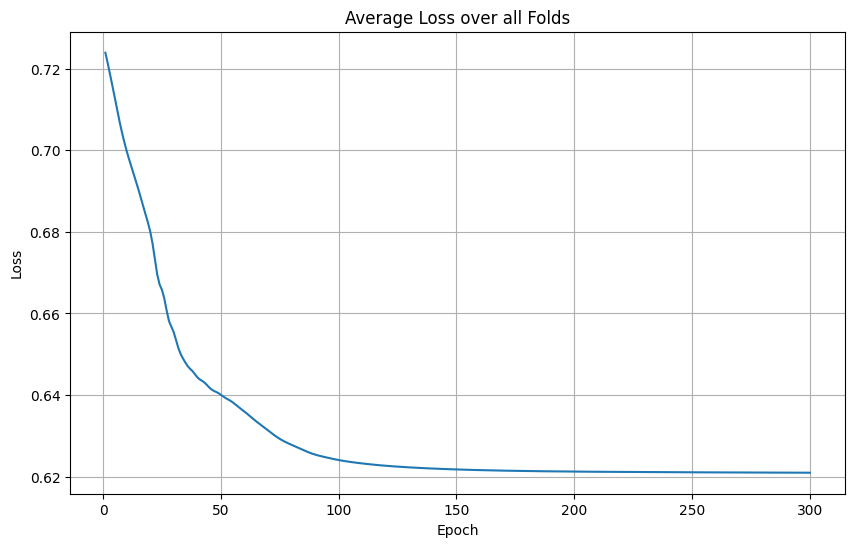

In [70]:
epochs = np.arange(1, len(avg_loss) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, avg_loss, linestyle='-')
plt.title('Average Loss over all Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('GCNMLP_loss.pdf')
plt.show()